In [75]:
import os, sys
import numpy as np
import gymnasium as gym
import time
import text_flappy_bird_gym
from collections import defaultdict
import matplotlib.pyplot as plt

In [76]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

### Monte Carlo Based Agent

In [77]:
class MonteCarloAgent:
    def __init__(self, env, alpha, gamma=1.0, eps_start=1.0, eps_decay=0.99999, eps_min=0.05):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.nA = env.action_space.n
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.epsilon = eps_start
    
    def set_environment(self, env):
        self.env = env

    def get_probs(self, Q_s, epsilon):
        policy_s = np.ones(self.nA) * epsilon / self.nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / self.nA)
        return policy_s

    def policy(self, state):
        action = np.random.choice(np.arange(self.nA), p=self.get_probs(self.Q[state], self.epsilon)) \
                     if state in self.Q else self.env.action_space.sample()
        return action

    def generate_episode_from_Q(self):
        episode = []
        state = self.env.reset()[0]
        while True:
            action = self.policy(state)
            next_state, reward, done, _, info = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break

        score = info["score"]
        return episode, score

    def update_Q(self, episode):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma ** i for i in range(len(rewards) + 1)])
        for i, state in enumerate(states):
            old_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = old_Q + self.alpha * (
                    sum(rewards[i:] * discounts[:-(i + 1)]) - old_Q)

    def mc_control(self, num_episodes):
        reward_list = []
        score_list = []

        for i_episode in range(1, num_episodes + 1):
            if i_episode % 1000 == 0:
                print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
                sys.stdout.flush()

            self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)
            episode, score = self.generate_episode_from_Q()
            score_list.append(score)
            _, _, rewards = zip(*episode)
            reward_list.append(sum(rewards))
            self.update_Q(episode)

        policy = dict((k, np.argmax(v)) for k, v in self.Q.items())
        return policy, self.Q, reward_list, score_list

In [78]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
MCAgent = MonteCarloAgent(env, 0.02, 1, 1, 0.99999, 0.05)
num_episodes = 50000

policy_mc, Q_mc, reward_list, score_list = MCAgent.mc_control(num_episodes)

Episode 50000/50000.

Text(0.5, 1.0, 'Policy - Monte Carlo')

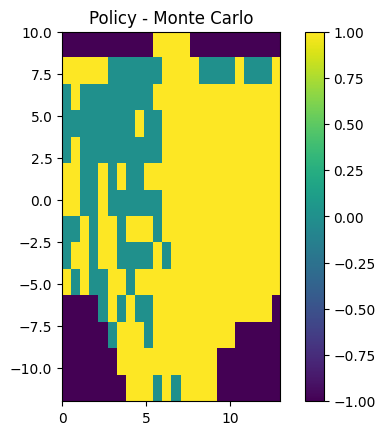

In [79]:
policy_table_mc = np.zeros((14,24)) - 1
for k in policy_mc.keys():
    policy_table_mc[k[0], k[1] + 12] = policy_mc[k]

plt.imshow(policy_table_mc, extent = [0, 13, -12, 10])
plt.colorbar()
plt.title("Policy - Monte Carlo")

In [80]:
keys = Q_mc.keys()
# find the boundary for x_pos and y_pos
# Find the boundary for x_pos and y_pos
x_min = min(state[0] for state in keys)
x_max = max(state[0] for state in keys)
y_min = min(state[1] for state in keys)
y_max = max(state[1] for state in keys)

state_values = np.zeros((x_max - x_min, y_max - y_min))

for i in range(x_min, x_max):
    for j in range(y_min, y_max):
        state = (i, j)
        if state in Q_mc:
            state_values[i, j] = np.max(Q_mc[state])
        else:
            state_values[i, j] = 0

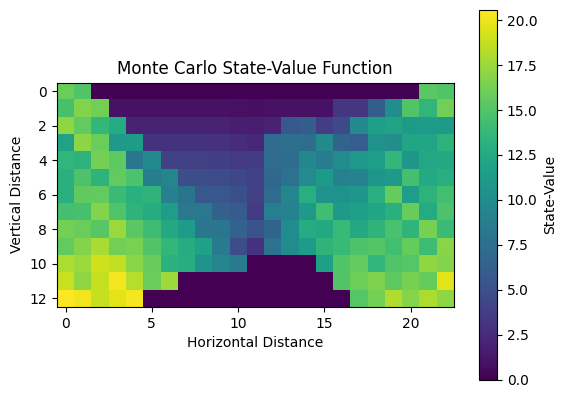

In [81]:
plt.imshow(state_values, cmap='viridis')
plt.colorbar(label='State-Value')
plt.title('Monte Carlo State-Value Function')
plt.xlabel('Horizontal Distance')
plt.ylabel('Vertical Distance')
plt.show()

### Sarsa($\lambda$) agent

In [99]:
class SarsaLambdaAgent:
    def __init__(self, env, alpha, lambd, gamma = 1.0, eps_start = 1.0, eps_decay=0.99999, eps_min=0.05):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.lambd = lambd
        self.num_actions = env.action_space.n
        self.epsilon = eps_start
        
        self.Q = defaultdict(lambda: np.zeros(self.num_actions))
        self.eligibility_trace = defaultdict(lambda: np.zeros(self.num_actions))

        self.prev_state = None
        self.prev_action = None

    def set_environment(self, env):
        self.env = env

    def agent_start(self, state):
        current_q = self.Q[state]
        action = self.epsilon_greedy(current_q)

        self.prev_state = state
        self.prev_action = action
        return action


    def agent_step(self, reward, next_state):
        current_q = self.Q[next_state]
        next_action = self.epsilon_greedy(current_q)

        td_error = reward + self.gamma * current_q[next_action] - self.Q[self.prev_state][self.prev_action]

        self.eligibility_trace[self.prev_state][self.prev_action] += 1
        for state, actions in self.Q.items():
            for action in range(self.num_actions):
                self.Q[state][action] += self.alpha * td_error * self.eligibility_trace[state][action]
                self.eligibility_trace[state][action] *= self.gamma * self.lambd

        self.prev_state = next_state
        self.prev_action = next_action

        return next_action


    def agent_end(self, reward):
        td_error = reward - self.Q[self.prev_state][self.prev_action]

        self.eligibility_trace[self.prev_state][self.prev_action] += 1
        for state, actions in self.Q.items():
            for action in range(self.num_actions):
                self.Q[state][action] += self.alpha * td_error * self.eligibility_trace[state][action]
                self.eligibility_trace[state][action] *= self.gamma * self.lambd


    def epsilon_greedy(self, q_values):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return self.argmax(q_values)

    def argmax(self, q_values):
        top = np.max(q_values)
        ties = np.where(q_values == top)[0]
        return np.random.choice(ties)

In [129]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
num_episodes = 50000
sarsaAgent = SarsaLambdaAgent(env, 0.02, 0.9)

In [131]:
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()[0]
    action = sarsaAgent.agent_start(state)
    done = False
    total_reward = 0

    if episode % 1000 == 0:
        print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
        sys.stdout.flush()

    sarsaAgent.epsilon = max(sarsaAgent.epsilon * sarsaAgent.eps_decay, sarsaAgent.eps_min)
    while not done:
        next_state, reward, done, _, info = env.step(action)
        total_reward += reward
        
        if done:
            sarsaAgent.agent_end(reward)
        else:
            next_action = sarsaAgent.agent_step(reward, next_state)
            action = next_action
    episode_rewards.append(total_reward)

Episode 0/50000.

Episode 49000/50000.

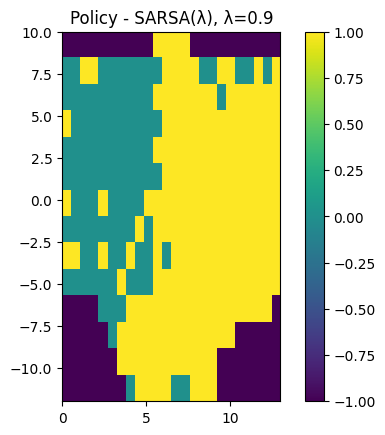

In [132]:
policy_table_sarsa = np.zeros((14, 24)) - 1
for k in sarsaAgent.Q.keys():
    policy_table_sarsa[k[0], k[1] + 12] = np.argmax(sarsaAgent.Q[k])

plt.imshow(policy_table_sarsa, extent=[0, 13, -12, 10])
plt.colorbar()
plt.title("Policy - SARSA(λ), λ=0.9")
plt.show()

In [133]:
keys = sarsaAgent.Q.keys()
# find the boundary for x_pos and y_pos
# Find the boundary for x_pos and y_pos
x_min = min(state[0] for state in keys)
x_max = max(state[0] for state in keys)
y_min = min(state[1] for state in keys)
y_max = max(state[1] for state in keys)

state_values = np.zeros((x_max - x_min, y_max - y_min))

for i in range(x_min, x_max):
    for j in range(y_min, y_max):
        state = (i, j)
        if state in sarsaAgent.Q:
            state_values[i, j] = np.max(sarsaAgent.Q[state])
        else:
            state_values[i, j] = 0

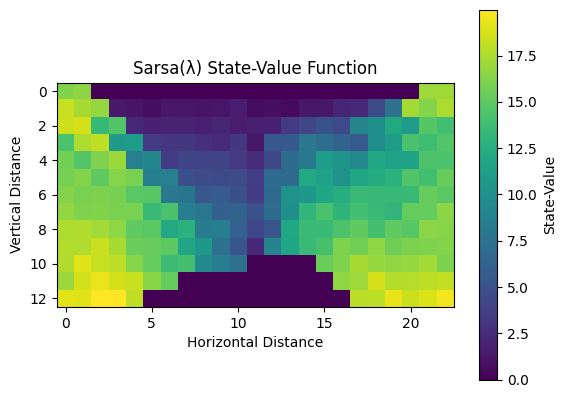

In [134]:
plt.imshow(state_values, cmap='viridis')
plt.colorbar(label='State-Value')
plt.title('Sarsa(λ) State-Value Function')
plt.xlabel('Horizontal Distance')
plt.ylabel('Vertical Distance')
plt.show()

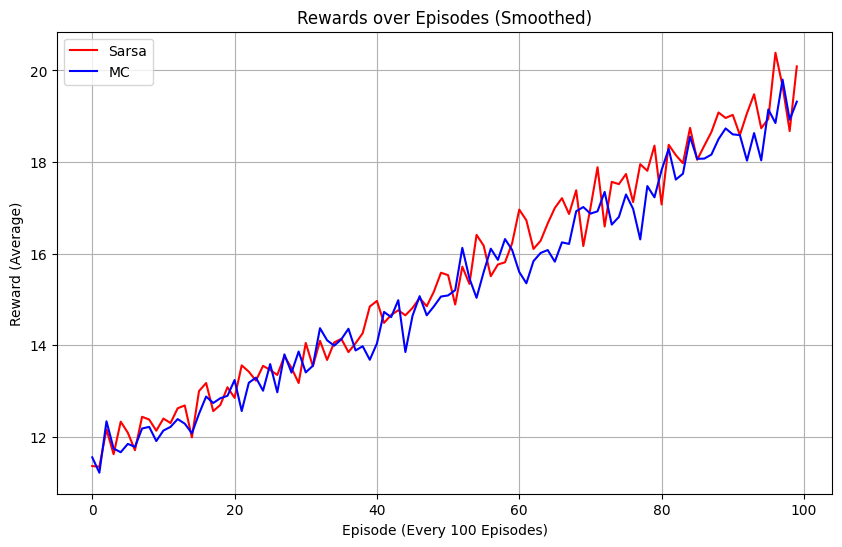

In [135]:
def rolling_average(data, window_size):
    averages = []
    for i in range(0, len(data), window_size):
        window = data[i:i+window_size]
        averages.append(np.mean(window))
    return np.array(averages)

window_size = 500

plt.figure(figsize=(10, 6))
plt.plot(rolling_average(episode_rewards, window_size), color='red', label='Sarsa')
plt.plot(rolling_average(reward_list, window_size), color='blue', label='MC')
plt.title('Rewards over Episodes (Smoothed)')
plt.xlabel('Episode (Every 100 Episodes)')
plt.ylabel('Reward (Average)')
plt.legend()
plt.grid(True)
plt.show()

# Other Level configuration

In [136]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
MCAgent = MonteCarloAgent(env, 0.02, 1, 1, 0.99999, 0.05)
num_episodes = 50000

policy_mc, Q_mc, reward_list, score_list = MCAgent.mc_control(num_episodes)

Episode 50000/50000.

In [90]:
def avg_reward():
    num_episodes = 10000

    reward_list = []
    for episode in range(num_episodes):
        episode = []
        state = MCAgent.env.reset()[0]
        while True:
            action = MCAgent.policy(state)
            next_state, reward, done, _, info = MCAgent.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break

        _, _, rewards = zip(*episode)
        reward_list.append(sum(rewards))
    
    return np.average(reward_list)

In [74]:
reward_1 = avg_reward()
print(reward_1)

19.0199


In [91]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 25, pipe_gap = 4)
obs = env.reset()
MCAgent.set_environment(env)

reward_2 = avg_reward()
print(reward_2)

20.2092


In [92]:
env = gym.make('TextFlappyBird-v0', height = 20, width = 20, pipe_gap = 4)
obs = env.reset()
MCAgent.set_environment(env)

reward_3 = avg_reward()
print(reward_3)

18.313


In [93]:
env = gym.make('TextFlappyBird-v0', height = 25, width = 25, pipe_gap = 4)
obs = env.reset()
MCAgent.set_environment(env)

reward_4 = avg_reward()
print(reward_4)

20.0173


In [94]:
env = gym.make('TextFlappyBird-v0', height = 30, width = 30, pipe_gap = 4)
obs = env.reset()
MCAgent.set_environment(env)

reward_5 = avg_reward()
print(reward_5)

20.7599


In [145]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 2)
obs = env.reset()
MCAgent.set_environment(env)

reward_6 = avg_reward()
print(reward_6)

14.3423


In [146]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 1)
obs = env.reset()
MCAgent.set_environment(env)

reward_8 = avg_reward()
print(reward_8)

12.6016


In [141]:
def avg_reward_sarsa():
    num_episodes = 10000
    reward_list = []

    for episode in range(num_episodes):
        state = sarsaAgent.env.reset()[0]
        action = sarsaAgent.agent_start(state)
        total_reward = 0
        done = False
        
        while not done:
            next_state, reward, done, _, info = sarsaAgent.env.step(action)
            total_reward += reward
            
            if done:
                break
            else:
                current_q = sarsaAgent.Q[next_state]
                next_action = sarsaAgent.epsilon_greedy(current_q)
                action = next_action
        reward_list.append(total_reward)
    
    return np.average(reward_list)

In [142]:
# env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
reward_9 = avg_reward_sarsa()
print(reward_9)

19.7722


In [147]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 25, pipe_gap = 4)
obs = env.reset()
sarsaAgent.set_environment(env)
reward_10 = avg_reward_sarsa()
print(reward_10)

20.5125


In [148]:
env = gym.make('TextFlappyBird-v0', height = 20, width = 20, pipe_gap = 4)
obs = env.reset()
sarsaAgent.set_environment(env)
reward_11 = avg_reward_sarsa()
print(reward_11)

18.9412


In [149]:
env = gym.make('TextFlappyBird-v0', height = 25, width = 25, pipe_gap = 4)
obs = env.reset()
sarsaAgent.set_environment(env)
reward_10 = avg_reward_sarsa()
print(reward_10)

20.8597


In [150]:
env = gym.make('TextFlappyBird-v0', height = 30, width = 30, pipe_gap = 4)
obs = env.reset()
sarsaAgent.set_environment(env)
reward_11 = avg_reward_sarsa()
print(reward_11)

21.093


In [151]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 2)
obs = env.reset()
sarsaAgent.set_environment(env)
reward_12 = avg_reward_sarsa()
print(reward_12)

14.6926


In [152]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 1)
obs = env.reset()
sarsaAgent.set_environment(env)
reward_13 = avg_reward_sarsa()
print(reward_13)

12.7058
